In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


import pickle

import sys
sys.path.append("../../neuroppl/")
sys.path.append("..")
sys.path.append("../scripts/")


import neuroppl as nppl
from neuroppl import utils


import matplotlib.pyplot as plt

import os
if not os.path.exists('./saves'):
    os.makedirs('./saves')


import pickle


import lib


gpu_dev = 0
dev = utils.pytorch.get_device(gpu_dev)
#plt.style.use(['paper.mplstyle'])

PyTorch version: 1.7.1+cu101
Using device: cuda:0


In [57]:
# input stimulus
T = 4000
runs = 1

Tp = 100
T_int = 1000
I_ext = np.zeros((runs, T))

# biophysical model synthetic data
dynamics = 'spike_latency'#'bistability_II'#'tonic_spiking'#

model, I, dt = nppl.spiking_nets.biophysical.neuron_model(dynamics, 'Izhikevich')
sample_bin = dt
        
#for r in range(runs):    
#I_ext[0, T_int:-T_int] = I#I*np.sin(np.arange(T-2*T_int)/(T-2*T_int)*5*np.pi)
I_ext[0, T_int:Tp+T_int] = I
I_ext[0, -Tp-T_int:-T_int] = I

ic = np.empty((runs, 2))
ic[:, 0] = -60.
ic[:, 1] = 0.

state, spiketrain = model.euler_int(T, runs, I_ext, ic, dt=dt)

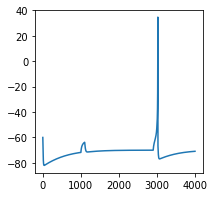

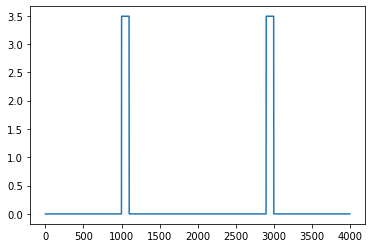

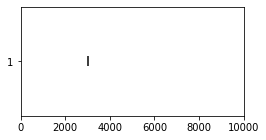

In [58]:
# visualize data
plt.figure(figsize=(3,3))
plt.plot(state[0, :, 0])
plt.show()


plt.plot(I_ext[0, :])
plt.show()

fig, ax = plt.subplots(figsize=(4, 2))
utils.plot.raster_plot((fig, ax), spiketrain, 10000, dt*10, runs, markersize=100)
plt.show()

### Head direction cells

In [183]:
cov[:, 5, :].mean()

tensor(nan, dtype=torch.float64)

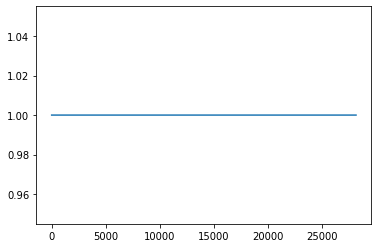

In [188]:
plt.plot(cov[:, 1, :].mean(-1) == cov[:, 1, :].mean(-1))

In [211]:
cov = model_utils.pp_covariates(rcov, syn_inds[0], H_isi, hist_len, dt).numpy()

In [213]:
cov[:, 5, 0]

array([ 49.,  49.,  49., ..., 885., 885., 885.])

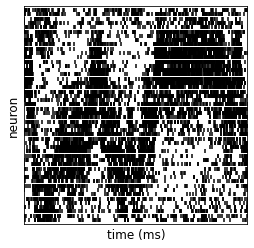

In [135]:
fig, ax = plt.subplots(figsize=(4,4))

neurons = rc_t.shape[0]
tbin = 0.001
utils.plot.raster_plot((fig, ax), syn_train[0][:100], 30000, tbin*1000, neurons, markersize=10)
utils.plot.decorate_ax(ax, xlabel='time (ms)', ylabel='neuron')

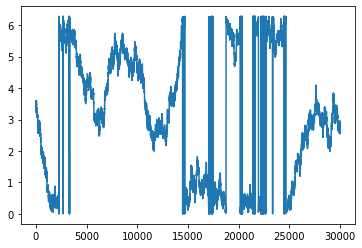

In [122]:
plt.plot(hd_t[0, :])

In [55]:
hd_t.shape

(1, 30000)

### Place cells

In [73]:
# animal behaviour
def arena_behaviour(arena_data, track_samples, sample_bin):
    left_x, right_x, bottom_y, top_y, tc = arena_data
    
    arena_width = right_x - left_x
    arena_height = top_y - bottom_y
    
    arena = [('wall', (np.array([right_x+tc, bottom_y-tc]), 
                       np.array([left_x-tc, bottom_y-tc]), tc)), 
             ('wall', (np.array([left_x-tc, bottom_y-tc]), 
                       np.array([left_x-tc, top_y+tc]), tc)), 
             ('wall', (np.array([left_x-tc, top_y+tc]), 
                       np.array([right_x+tc, top_y+tc]), tc)), 
             ('wall', (np.array([right_x+tc, top_y+tc]), 
                       np.array([right_x+tc, bottom_y-tc]), tc))]
    #arena = [('arc', (np.array([250., 200.]), 
    #                   0., 2*np.pi, 200.0+tc, tc))]

    an = lib.animal.animal_SL(sample_bin, track_samples, arena)
    sample_bin, sim_samples, x_t, y_t, \
        s_t, dir_t, hd_t, theta_t = \
        an.sample(0.01, [200.0, 200.0], 100, 0.14, 0.0)
    
    #an = animal.animal_Lever(sample_bin, track_samples, arena)
    #sample_bin, sim_samples, x_t, y_t, \
    #    s_t, dir_t, hd_t, theta_t = \
    #    an.sample(np.array([200.0, 200.0]), 140., 0., 0.3, .14, 0.)
    
    wrap_theta_t = theta_t % (2*np.pi)
    behav_data = [x_t, y_t, wrap_theta_t]
    
    return behav_data

In [68]:
def place_cell(model):
    
    if model == 'mix':
        # Mixture of Gaussians
        mu = np.array([[100., 100.]])
        prec = np.array([[0.0002, 0.0002, 0.0]])
        rate_0 = np.array([10.0]) # Hz
        t_p = np.array([[1.0, 0.2]]) # beta, phi_0 for theta modulation
        neurons = rate_0.shape[0]

        gauss_1 = lib.rate_models.Gauss_GLM(neurons, 'exp')
        gauss_1.set_params(mdl.rate_models.gaussian_to_w(mu, prec, rate_0, t_p)[:, :6])

        mu = np.array([[170., 350.]])
        prec = np.array([[0.0002, 0.0002, 0.0]])
        rate_0 = np.array([10.0]) # Hz
        t_p = np.array([[1.0, 0.2]]) # beta, phi_0 for theta modulation
        neurons = rate_0.shape[0]

        gauss_2 = lib.rate_models.Gauss_GLM(neurons, 'exp')
        gauss_2.set_params(mdl.rate_models.gaussian_to_w(mu, prec, rate_0, t_p)[:, :6])

        mu = np.array([[400., 225.]])
        prec = np.array([[0.0003, 0.0001, 0.0]])
        rate_0 = np.array([10.0]) # Hz
        t_p = np.array([[1.0, 0.2]]) # beta, phi_0 for theta modulation
        neurons = rate_0.shape[0]

        gauss_3 = lib.rate_models.Gauss_GLM(neurons, 'exp')
        gauss_3.set_params(mdl.rate_models.gaussian_to_w(mu, prec, rate_0, t_p)[:, :6])

        gauss_rate = nppl.mappings.mixture_model(3, [gauss_1, gauss_2, gauss_3])
        inv_link = 'relu'
        
        w_h = np.array([[[-0.1]], [[-1.0]]])
        phi_h = np.array([[[3.0]], [[1.0]]])
        
    elif model == 'gauss':
        # Gaussian fields with theta
        mu = np.array([[250., 250.], [100., 100.], [400., 300.], [50., 350.], [360., 70.]])
        prec = np.array([[0.0001, 0.0001, 0.00005], [0.0002, 0.0002, 0.0], [0.0001, 0.0002, 0.00005], 
                         [0.0001, 0.0002, 0.0], [0.00015, 0.00015, 0.0]])
        rate_0 = np.array([8.0, 20.0, 10.0, 17.0, 12.0]) # Hz
        t_p = np.array([[0.0, 0.0], [1.0, 0.2], [0.5, 0.0], [0.7, 1.0], [0.1, 0.0]]) # beta, phi_0 for theta modulation

        neurons = rate_0.shape[0]

        gauss_rate = lib.rate_models.Gauss_GLM(neurons, 'exp')
        gauss_rate.set_params(lib.rate_models.gaussian_to_w(mu, prec, rate_0, t_p)[:, :6])
        inv_link = 'exp'
        
        w_h = np.array([-0.1,-1.0])[:, None, None]*np.ones((2, 5, 5))
        phi_h = np.array([[[3.0, 3.0, 3.0, 3.0, 3.0]], [[1.0, 1.0, 1.0, 1.0, 1.0]]])

    return gauss_rate, inv_link

In [76]:
dt = 0.001
track_samples = 300000


mapping, inv_link = place_cell('gauss')

neurons = 1
hist_couple = None
shape_t = 2.0*np.ones(neurons)
likelihood = nppl.likelihoods.Gamma(dt, neurons, inv_link, shape_t)
#sigma_t = 0.5*np.ones(neurons)
#likelihood = mdl.likelihoods.logNormal(sample_bin, neurons, inv_link, sigma_t)
#mu_t = 5.0*np.ones(neurons)
#likelihood = mdl.likelihoods.invGaussian(neurons, inv_link, mu_t)


lib.helper.sample_Y()


TypeError: zeros() received an invalid combination of arguments - got (tuple, dtype=str), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [74]:
left_x = 0.0
right_x = 538.4177999999999
bottom_y = 0.0
top_y = 432.3225
tc = 10.
arena_data = (left_x, right_x, bottom_y, top_y, tc)



behav_data = arena_behaviour(arena_data, track_samples, dt)

KeyboardInterrupt: 

In [75]:
# sample and convert
syn_train = lib.helper.sample_Y(mapping, likelihood, behav_data, trials=1, MC=1)

syn_inds = []
for train_ in syn_train:
    syn_inds_ = []
    for train__ in train_:
        syn_inds_.append(utils.neural.binned_to_indices(train__))
        
    syn_inds.append(syn_inds_)


NameError: name 'mapping' is not defined

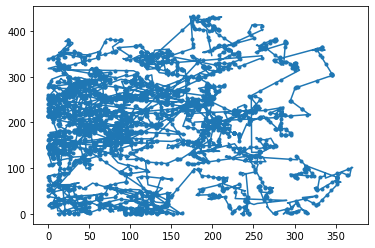

In [115]:
x, y, th = behav_data
plt.scatter(x[syn_inds[0][0]], y[syn_inds[0][0]], marker='.')
plt.plot(x, y)
plt.show()

In [ ]:
mode = 'GMM_gamma+'

tbin, track_samples, x_t, y_t, s_t, hd_t, theta_t, dir_t, \
    syn_t_spike, spike_samples, neurons, \
    left_x, right_x, bottom_y, top_y = pickle.load(open('./checkpoint/{}.p'.format(mode), 'rb'))